# Линейная регрессия на torch для boston house price

In [1]:
# загружаем данные

!pip3 install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [3]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [4]:
%load_ext pycodestyle_magic

In [5]:
!chmod 600 kaggle.json

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d vikrishnan/boston-house-prices

  0% 0.00/12.8k [00:00<?, ?B/s]
100% 12.8k/12.8k [00:00<00:00, 20.5MB/s]


In [8]:
!unzip /content/boston-house-prices.zip

Archive:  /content/boston-house-prices.zip
  inflating: housing.csv             


In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

Названия и описания переменных из описания датасета: 
*   CRIM per capita crime rate by town ZN proportion of residential land zoned for lots over 25,000 sq.ft.
*   INDUS proportion of non-retail business acres per town
*   CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
*   NOX nitric oxides concentration (parts per 10 million)
*   RM average number of rooms per dwelling
*   AGE proportion of owner-occupied units built prior to 1940
*   DIS weighted distances to five Boston employment centres
*   RAD index of accessibility to radial highways
*   TAX full-value property-tax rate per $10,000

*   PTRATIO pupil-teacher ratio by town
*   B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
*   LSTAT % lower status of the population
*   **MEDV Median value of owner-occupied homes in $1000's**

In [10]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'ACE',
         'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [11]:
df = pd.read_csv('housing.csv', header=None, names=names, dtype='float64',
                 delim_whitespace=True)

In [12]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,ACE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
# нормализуем данные

df[df.columns[:-1]] = df[df.columns[:-1]].apply(
    lambda x: (x - x.mean()) / x.std()
)

In [14]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,ACE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419367,0.284548,-1.286636,-0.272329,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499,24.0
1,-0.416927,-0.487240,-0.592794,-0.272329,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953,21.6
2,-0.416929,-0.487240,-0.592794,-0.272329,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,0.396035,-1.207532,34.7
3,-0.416338,-0.487240,-1.305586,-0.272329,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,0.415751,-1.360171,33.4
4,-0.412074,-0.487240,-1.305586,-0.272329,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,0.440616,-1.025487,36.2


In [15]:
# преобразуем X и y в numpy-формат

X = df.drop('MEDV', axis=1).to_numpy()
Y = df['MEDV'].to_numpy()

In [16]:
# разобьём датасет на обучающий и тестовый для оценки качества

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [17]:
X_train.shape

(379, 13)

In [18]:
X_test.shape

(127, 13)

In [19]:
y_train.shape

(379,)

In [20]:
y_test.shape

(127,)

In [21]:
# преобразуем выборки в тензоры

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

In [22]:
# обернём выборки в TensorDataset и DataLoader-ы
# размер батча лучше выбрать 16, а не 8, не только потому, что 16=2^4,
# но и потому, что так обучающая и тестовая выборки (379 и 127 образцов)
# ровнее разбиваются на батчи

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
model = torch.nn.Sequential(torch.nn.Linear(13, 1))

In [24]:
# инициализуем случайные нормированные через std=0.1 веса и нулевые bias

torch.nn.init.normal_(model[0].weight, mean=0, std=0.1)
torch.nn.init.constant_(model[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [25]:
trainer = torch.optim.SGD(model.parameters(), lr=0.05)

In [26]:
loss = torch.nn.MSELoss(reduction='mean')

In [27]:
# сохраним все значения функции потерь
# и построим график лоссов после завершения обучения

num_epochs = 100
losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    for x, y in train_loader:
        output = model(x)
        curr_loss = loss(output, y)
        losses.append(curr_loss.item())
        trainer.zero_grad()
        curr_loss.backward()
        trainer.step()

100%|██████████| 100/100 [00:01<00:00, 75.22it/s]


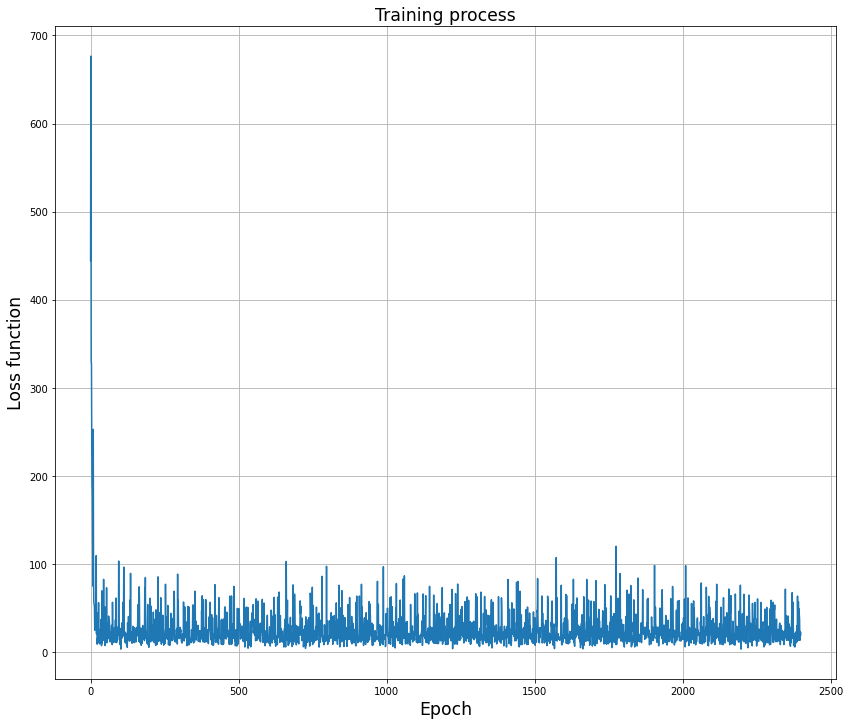

In [28]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

Посчитаем loss для обучающей и для тестовой выборки по завершении обучения.

In [29]:
losses[-1]

22.136627197265625

In [30]:
loss(model(X_test), y_test).item()

23.96484375

Loss нормальный.

# Наивный байесовский классификатор для MNIST

## Демонстрация "чёрно-белого" датасета MNIST

In [31]:
import torchvision
from scipy.special import logsumexp
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score, classification_report

In [32]:
def transform(data):
    data = torch.tensor(data.getdata(), dtype=torch.float32)
    return torch.floor(data / 128.).squeeze(axis=-1)

In [33]:
mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform,
                                         download=True)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform,
                                         download=True)
clear_output()

In [34]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: <function transform at 0x7fa0bbd37400>

In [35]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: <function transform at 0x7fa0bbd37400>

In [36]:
mnist_train[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0.,

In [37]:
mnist_train[0][0].shape

torch.Size([784])

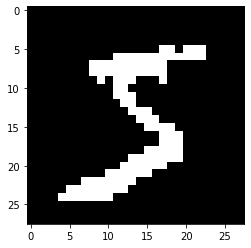

In [38]:
plt.imshow(mnist_train[0][0].reshape(28, 28), cmap='gray', vmin=0, vmax=1)

## Своя реализация наивного байесовского классификатора
Аргументы "priors", и "sample_weight" я не стала реализовывать, т. к., это оказалось слишком сложным. Аналогично вместо методов fit() и partial_fit() реализован только fit() (поэтому на больших массивах данных мой классификатор работает значительно медленнее sklearn-овского). Также не реализовывала метод score, т. к., он предназначен для мультиклассовой классификации, а у нас бинарная.

In [67]:
class NaiveBayesClassifier():
    def __init__(self, var_smoothing=1e-9):
        # инициализируем вероятности классов
        # для необученного классификатора как None
        self.class_prior_ = None
        self.var_smoothing = var_smoothing

    def __repr__(self):
        return f'NaiveBayesClassifier(var_smoothing={self.var_smoothing})'

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        if X.size == 0:
            raise ValueError('No samples are provided!')
        if X.shape[1] == 0:
            raise ValueError('No features are provided!')
        if y.size == 0:
            raise ValueError('No classes are provided!')
        self.classes_, self.class_count_ = np.unique(y, return_counts=True)
        self.epsilon_ = self.var_smoothing * np.var(X, axis=0).max()
        # считаем среднее и дисперсию каждого признака по классам
        self.sigma_ = []
        self.theta_ = []
        for class_ in self.classes_:
            X_class_ = X[np.argwhere(Y == class_)]
            self.sigma_.append(np.var(X_class_, axis=0))
            self.theta_.append(np.mean(X_class_, axis=0))
        self.sigma_ = np.concatenate(self.sigma_, axis=0)
        self.theta_ = np.concatenate(self.theta_, axis=0)
        self.sigma_[:, :] += self.epsilon_
        self.class_prior_ = self.class_count_ / self.class_count_.sum()
        return self

    def get_params(self):
        # возвращает значение параметра var_smoothing
        return {'var_smoothing': self.var_smoothing}

    def predict(self, X):
        # предсказывает всем объектам в тестовой выборке
        # самый частотный класс из обучающей выборки
        if self.class_prior_ is None:
            raise NotFittedError(
                'This NaiveBayesClassifier instance is not fitted yet.'
                )
        X = np.array(X)
        if X.size == 0:
            raise ValueError('No samples are provided!')
        if X.shape[1] != self.sigma_.shape[1]:
            raise ValueError('Incorrect number of features!')
        return np.full(X.shape[0], self.classes_[np.argmax(self.class_count_)])

    def predict_log_proba(self, X):
        # предсказывает всем объектам в тестовой выборке
        # логарифм вероятности принадлежности к каждому из двух классов
        if self.class_prior_ is None:
            raise NotFittedError(
                'This NaiveBayesClassifier instance is not fitted yet.'
                )
        X = np.array(X)
        if X.size == 0:
            raise ValueError('No samples are provided!')
        if X.shape[1] != self.sigma_.shape[1]:
            raise ValueError('Incorrect number of features!')
        log_likelihoods = []
        for i in range(np.size(self.classes_)):
            prior = np.log(self.class_prior_[i])
            minus = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
            minus -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
                                  (self.sigma_[i, :]), 1)
            log_likelihoods.append(prior + minus)
        log_likelihoods = np.array(log_likelihoods).T
        log_prob_x = logsumexp(log_likelihoods, axis=1)
        return log_likelihoods - np.atleast_2d(log_prob_x).T

    def predict_proba(self, X):
        # предсказывает всем объектам в тестовой выборке
        # вероятность принадлежности к каждому из двух классов
        return np.exp(self.predict_log_proba(X))

    def set_params(self, **params):
        # присваивает заданные значения заданным параметрам
        for param, value in params.items():
            if param != 'var_smoothing':
                raise ValueError(f'Invalid param {param}!')
            setattr(self, param, value)
        return self

## Проверка
Для начала сравним работу этой реализации классификатора и классификатора sklearn на простейшем наборе данных ([из документации sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)).

In [68]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])

In [69]:
clf_sklearn = GaussianNB()
clf_custom = NaiveBayesClassifier()

In [70]:
clf_sklearn.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [71]:
clf_custom.get_params()

{'var_smoothing': 1e-09}

In [72]:
clf_sklearn.set_params(**{'var_smoothing': 1.0})

GaussianNB(priors=None, var_smoothing=1.0)

In [73]:
clf_custom.set_params(var_smoothing=1.0)

NaiveBayesClassifier(var_smoothing=1.0)

In [74]:
clf_sklearn.set_params(foo='bar')

ValueError: ignored

In [75]:
clf_custom.set_params(**{'bar': 'foo'})

ValueError: ignored

In [76]:
clf_sklearn.set_params(var_smoothing=1e-09)

GaussianNB(priors=None, var_smoothing=1e-09)

In [77]:
clf_custom.set_params(var_smoothing=1e-09)

NaiveBayesClassifier(var_smoothing=1e-09)

In [78]:
clf_sklearn.fit(X, Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [79]:
clf_custom.fit(X, Y)

NaiveBayesClassifier(var_smoothing=1e-09)

In [80]:
clf_sklearn.predict([[-0.8, -1]])

array([1])

In [81]:
clf_custom.predict([[-0.8, -1]])

array([1])

Пока всё правильно и предсказуемо. Посмотрим, будут ли различия в predict_proba и predict_log_proba.

In [82]:
clf_sklearn = GaussianNB()
clf_custom = NaiveBayesClassifier()

In [83]:
clf_sklearn.fit(X, Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [84]:
clf_custom.fit(X, Y)

NaiveBayesClassifier(var_smoothing=1e-09)

In [85]:
clf_sklearn.predict_proba([[-0.8, -1]])

array([[9.99999949e-01, 5.05653254e-08]])

In [86]:
clf_custom.predict_proba([[-0.8, -1]])

array([[9.99999949e-01, 5.05653254e-08]])

In [87]:
clf_sklearn.predict_log_proba([[-0.8, -1]])

array([[-5.05653266e-08, -1.67999998e+01]])

In [88]:
clf_custom.predict_log_proba([[-0.8, -1]])

array([[-5.05653266e-08, -1.67999998e+01]])

Всё идентично! Теперь проверим, насколько хорошо мой классификатор будет справляться с данными MNIST.

## Проверка на MNIST

In [89]:
# Приведём данные MNIST к удобному формату и уберём все цифры, кроме 1 и 2.
# Так как объём данных большой, для скорости будем все операции делать со списками,
# а уже потом соединять их в массивы numpy.

X_train, X_test, y_train, y_test = [], [], [], []

In [90]:
%%time
for x, y in tqdm(mnist_train):
    if y == 1 or y == 2:
        X_train.append([list(x.numpy())])
        y_train.append(y)

100%|██████████| 60000/60000 [00:06<00:00, 9047.97it/s]

CPU times: user 6.46 s, sys: 175 ms, total: 6.63 s
Wall time: 6.63 s


6.63 s! Через нампаевские массивы оно бы считалось несколько часов.

In [91]:
%%time
for x, y in tqdm(mnist_test):
    if y == 1 or y == 2:
        X_test.append([list(x.numpy())])
        y_test.append(y)

100%|██████████| 10000/10000 [00:01<00:00, 9477.19it/s]

CPU times: user 1.02 s, sys: 36.6 ms, total: 1.06 s
Wall time: 1.06 s


In [92]:
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)

In [93]:
X_train.shape

(12700, 784)

In [94]:
X_test.shape

(2167, 784)

In [95]:
len(y_train)

12700

In [96]:
len(y_test)

2167

In [97]:
clf_sklearn = GaussianNB()
clf_custom = NaiveBayesClassifier()

In [98]:
clf_sklearn.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [99]:
y_pred = clf_sklearn.predict(X_test)

Результаты классификации для наивного байесовского классификатора из sklearn.

In [100]:
print(classification_report(y_test, y_pred, labels=[1, 2]))

              precision    recall  f1-score   support

           1       0.93      0.99      0.96      1135
           2       0.98      0.92      0.95      1032

    accuracy                           0.95      2167
   macro avg       0.96      0.95      0.95      2167
weighted avg       0.95      0.95      0.95      2167



In [102]:
clf_custom.fit(X_train, y_train)

NaiveBayesClassifier(var_smoothing=1e-09)

In [103]:
y_pred = clf_custom.predict(X_test)

Результаты классификации для нашего наивного байесовского классификатора.

In [105]:
print(classification_report(y_test, y_pred, labels=[1, 2], zero_division=1))

              precision    recall  f1-score   support

           1       0.52      1.00      0.69      1135
           2       1.00      0.00      0.00      1032

    accuracy                           0.52      2167
   macro avg       0.76      0.50      0.34      2167
weighted avg       0.75      0.52      0.36      2167



Своя реализация наивного байесовского классификатора работает заметно хуже sklearn-овского.